In [65]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import scipy.optimize as opt

#Requerimiento
Q_litros=2.5 #[L/min]
Q_gpm = Q_litros*0.264172/1 #[gal/min]
print("Q [gpm]",Q_gpm)
Q = Q_gpm*231/(60*12**3) #[ft3/s]
print("Q [ft3/s]",Q)
#H = 50 #[ft]

H_metros=3.5 #[m]
H=H_metros*3.28084 #[ft]

#Motor BLDC
RPM=8000 #[rpm]
n=RPM*np.pi/30 #[Rad/s]
print("n [rad/s]",n)

#Calcula Ns

Ns = n*Q**(1/2)/((32.2*H)**(3/4))
print("Ns",Ns)
#Cordier
if Ns > 0.85:
    Ds = (8.26/Ns)**0.517
else:
    Ds = (2.5/Ns)**1.092
print("Ds",Ds)    


#Diámetro en in
D = Ds*12*Q**0.5/((32.2*H)**(0.25))
print("Diámetro del rotor en in",D)

#Estimar el ojo mediante Wright
d = 12*D*1.53*(Q/(n*D**3))**(1/3)
print("d ojo [in]",d)

#Asumiendo b1 igual a d/4
b1 = d/4 #[in]
print("b1 [in]",b1)

#Se plantea el triángulo de velocidades a la entrada
U1 = d*n/(2*12) #[ft/s]
print("U1 [ft/s]",U1)
V1 = Q/(np.pi*d*b1/12**2) #[ft/s]
print("V1 [ft/s]",V1)
W1 = np.sqrt(U1**2+V1**2) #[ft/s]
print("W1 [ft/s]",W1)
beta1 = np.arctan(V1/U1)*180/np.pi #[grados]
print("Beta 1 [º]",beta1)
alfa1 = 90 #[grados]

#Triángulo de velocidades a la salida
U2 = D*n/(12*2) #[ft/s]
print("U2 [ft/s]",U2)
V2_r = V1 #[ft/s]
#Se determina b2 a partir del Q, que es el mismo de la entrada
b2 = 12*Q/(np.pi*(D/12)*V2_r)
print("b2 [in]",b2)

#Se estima la eficiencia para usar la ecuación de euler
Nsd = RPM*np.sqrt(Q_gpm)/(H**0.75)
print("Nsd",Nsd)

Q [gpm] 0.6604300000000001
Q [ft3/s] 0.0014714441550925928
n [rad/s] 837.7580409572781
Ns 0.3811173952418712
Ds 7.79891722414045
Diámetro del rotor en in 0.8186725093067154
d ojo [in] 0.2215207449780184
b1 [in] 0.0553801862445046
U1 [ft/s] 7.73253272267423
V1 [ft/s] 5.497782928284093
W1 [ft/s] 9.48776472272367
Beta 1 [º] 35.41259148838002
U2 [ft/s] 28.57706156593221
b2 [in] 0.014985064203869481
Nsd 1042.229980315857


Se usa el diagrama de eficiencia vs Nsd para estimar eta
![alt text](image.png)

In [66]:
eta = 0.63 #[Eficiencia de la bomba a partir del diagrama (Nsd y gpm)]

#Número adimensional de cabeza psi

Psi = 2*32.2*H/(eta*U2**2)
print("Psi",Psi)


Psi 1.4373524466842915


A partir del número adimensional de cabeza se determina B (lado de la garganta suponiendola cuadrada)
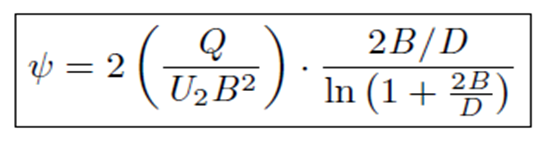

In [67]:
from scipy.optimize import fsolve

f = lambda x: Psi - 2*(Q/(U2*(x/12)**2))*(2*x/D)/np.log(1+2*x/D)
B = fsolve(f, 1e-1) #Lado de la garganta suponiendo que es cuadrada
print("B",B)
A_gar = B**2 #[in^2]
print("Área garganta",A_gar)
phi=Q/(U2*(B/12)**2)
print("phi",phi)


B [0.10780902]
Área garganta [0.01162278]
phi [0.63793806]


Se determina el factor Y
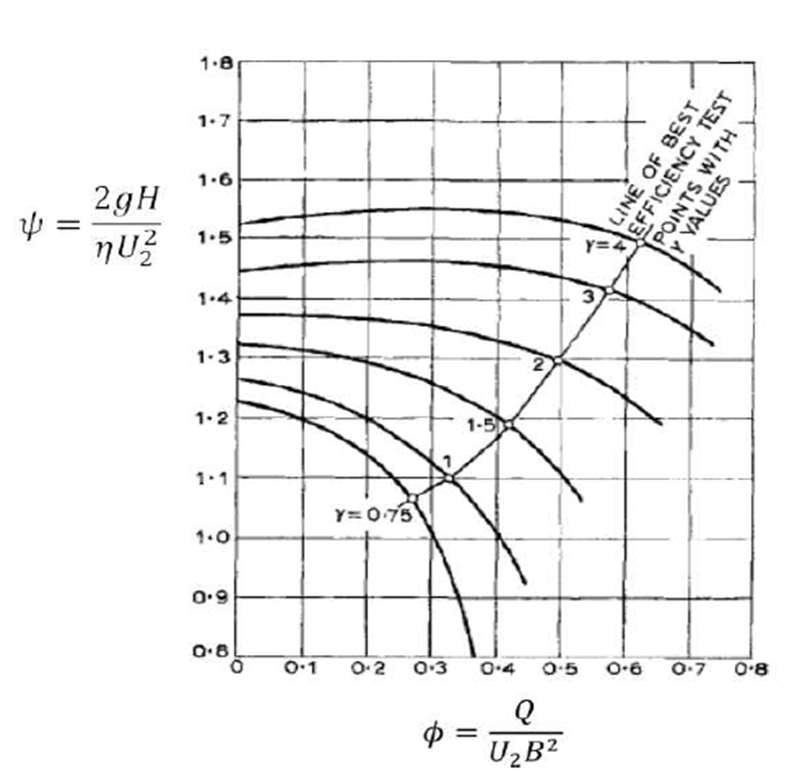

In [103]:
Y = 3

V2_th_K = 32.2*H/(U2*eta)
print("V2 tangencial con desilazamiento",V2_th_K)
V2 = np.sqrt(V2_r**2+V2_th_K**2)
print("V2 con deslizamiento",V2)

beta2 = np.atan(Y*A_gar/(np.pi*b2*D))*180/np.pi
print("beta 2 geometrica en grados",beta2)

beta2_k = np.atan(V2_r/(U2-V2_th_K))*180/np.pi
print("beta 2 real del flujo",beta2_k)

V2_th = U2 - V2_r/np.tan(beta2*np.pi/180)
print("V2 tangencial sin deslizamiento [ft/s]",V2_th)

alfa2 = np.atan(V2_r/V2_th_K)*180/np.pi
print("Alfa 2 en grados",alfa2)

dV_th = V2_th-V2_th_K
print("Diferencia entre velocidades tangenciales con y sin deslizamiento",dV_th)

W2 = V2_r/np.sin(beta2*np.pi/180)
print("W2 [ft/s]",W2)

K = 1 - dV_th/U2
print("K",K)

Rh=1-(V2**2-V1**2)/(2*(U2*V2_th))
print("Rh",Rh)

#Curva de la voluta
C=V2_th*D/(2*12) #[ft2/s]
tau=2*np.pi*C*B/(Q) #[s]

#Curva del alabe
R_alabe=(D**2-d**2)/(4*(D*np.cos(np.deg2rad(beta2))-d*np.cos(np.deg2rad(beta1)))) #[in]
print("Radio de curvatura del alabe [in]",R_alabe)
k_z=6.5
N_alabes=k_z*(D+d)/(D-d)*np.sin(0.5*(np.deg2rad(beta1)+np.deg2rad(beta2)))
print("Número de álabes",N_alabes)

V2 tangencial con desilazamiento 20.537654680420147
V2 con deslizamiento 21.26078260315729
beta 2 geometrica en grados [42.13618051]
beta 2 real del flujo 34.366440136619794
V2 tangencial sin deslizamiento [ft/s] [22.50026315]
Alfa 2 en grados 14.986294644402355
Diferencia entre velocidades tangenciales con y sin deslizamiento [1.96260847]
W2 [ft/s] [8.19469927]
K [0.93132224]
Rh [0.67200552]
Radio de curvatura del alabe [in] [0.36405737]
Número de álabes [7.09078172]


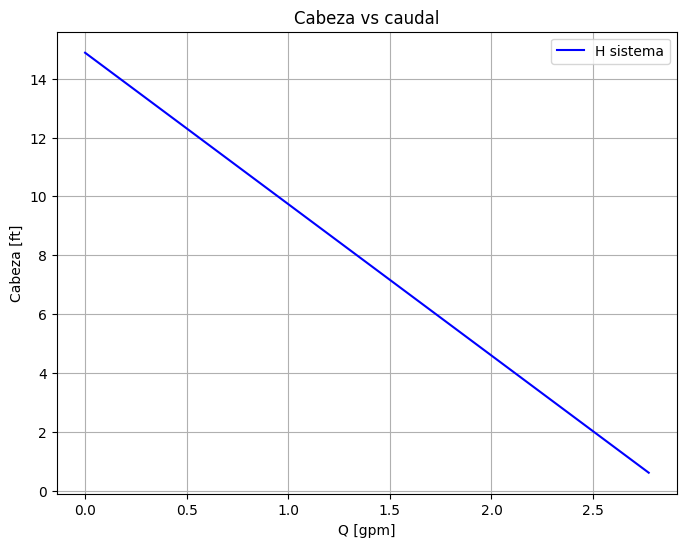

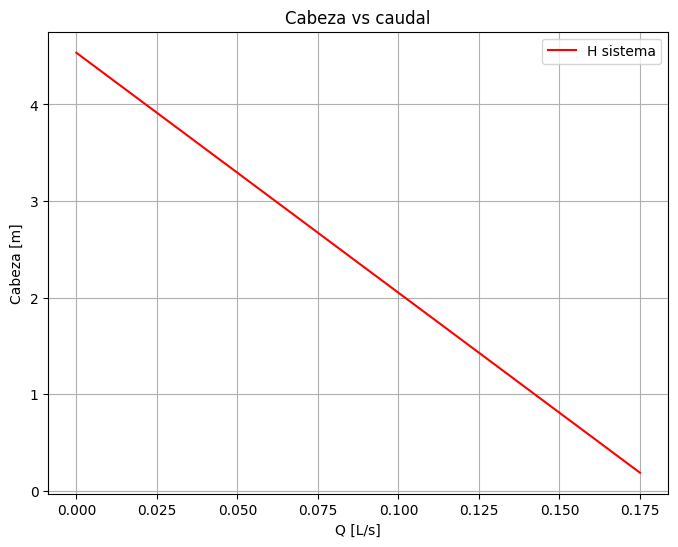

[0.         0.04374997 0.08749994 0.13124991 0.17499988]
[4.53559996 3.44822    2.36084004 1.27346008 0.18608012]


In [69]:
Q_graf_gpm = np.linspace(0,Q_gpm*4.2,5)
Q_graf_ft3 = Q_graf_gpm*231/(60*12**3)
H_graf = (eta*U2**2)/(2*32.2)*(2*K - 2*Q_graf_ft3/(np.pi*D*b2*U2*np.tan(beta2*np.pi/180)/144))

Q_graf_lt_s = Q_graf_gpm*3.78541/60
H_graf_m = H_graf/3.28084


plt.figure(figsize=(8,6))
plt.plot(Q_graf_gpm, H_graf, 'b-', label="H sistema")


plt.xlabel("Q [gpm]")
plt.ylabel("Cabeza [ft]")
plt.title("Cabeza vs caudal")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(Q_graf_lt_s, H_graf_m, 'r-', label="H sistema")
plt.xlabel("Q [L/s]")
plt.ylabel("Cabeza [m]")
plt.title("Cabeza vs caudal")
plt.legend()
plt.grid(True)
plt.show()

print(Q_graf_lt_s)
print(H_graf_m)

C:\Users\nicoa\AppData\Local\Temp\ipykernel_25040\438026205.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_blades = int(N_alabes)


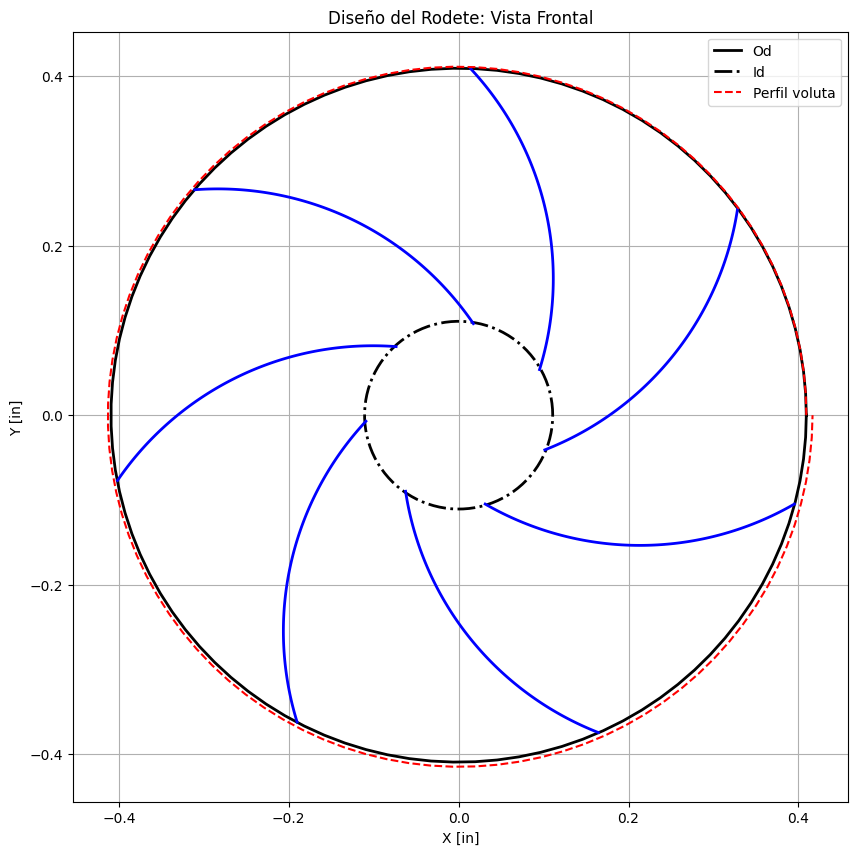

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def plot_blade_arc(xc, yc, R, start_angle, end_angle):
    theta = np.linspace(start_angle, end_angle, 100)
    x = xc + R * np.cos(theta)
    y = yc + R * np.sin(theta)
    plt.plot(x, y, 'b-', linewidth=2)

# Geometría del rodete
R = R_alabe  # Radio de curvatura del álabe [in]
d_2 = d/2    # Radio interno [in]
D_2 = D/2    # Radio externo [in]

# Ángulos en radianes
beta1_rad = np.deg2rad(beta1)
beta2_rad = np.deg2rad(beta2)

# Número de álabes
n_blades = int(N_alabes)

plt.figure(figsize=(10, 10))
# Dibujar círculos interno y externo del rodete
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(D_2*np.cos(theta), D_2*np.sin(theta), 'k-', linewidth=2, label='Od')
plt.plot(d_2*np.cos(theta), d_2*np.sin(theta), 'k-.', linewidth=2, label='Id')

# Dibujar los álabes
for i in range(n_blades):
    # Ángulo de posición del álabe
    angle = i * 2*np.pi/n_blades
    
    # Puntos en el radio interno y externo
    x1 = d_2 * np.cos(angle)  # punto inicial en radio interno
    y1 = d_2 * np.sin(angle)
    
    # Calcular centro del arco (desplazado del origen)
    dx = D_2 * np.cos(beta2_rad) - d_2 * np.cos(beta1_rad)
    dy = D_2 * np.sin(beta2_rad) - d_2 * np.sin(beta1_rad)
    
    # Rotar el centro según la posición del álabe
    cos_rot = np.cos(angle)
    sin_rot = np.sin(angle)
    xc = dx * cos_rot - dy * sin_rot
    yc = dx * sin_rot + dy * cos_rot
    
    # Calcular ángulos inicial y final
    start_angle = angle -np.pi + np.deg2rad(60)
    #start_angle = angle -np.pi + beta1_rad+ beta2_rad
    end_angle = angle - np.deg2rad(60)
    #end_angle = angle - (beta1_rad + beta2_rad)
    # Dibujar el arco
    plot_blade_arc(xc, yc, R, start_angle, end_angle)

plt.plot(D_2*np.exp(theta/tau)*np.cos(theta), D_2*np.exp(theta/tau)*np.sin(theta), 'r--', label='Perfil voluta')
plt.axis('equal')
plt.title('Diseño del Rodete: Vista Frontal')
plt.xlabel('X [in]')
plt.ylabel('Y [in]')
plt.grid(True)
plt.legend()
plt.show()